##### Downloading libraries 

In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import math

##### Print cities and connections

In [13]:
with open('json/2324_GIA04_CA5_Search_data_routes.json') as json_file:
    data = json.load(json_file)

cities = data['cities']
for city in cities:
    print(f"Name: {city['name']}")
    print(f"Address: {city['address']}")
    print(f"Country: {city['country']}")
    print(f"Latitude: {city['latitude']}")
    print(f"Longitude: {city['longitude']}")
    print()

connections = data['connections']
for connection in connections:
    print(f"From: {connection['from']}")
    print(f"To: {connection['to']}")
    print(f"Distance: {connection['distance']}")
    print(f"Duration: {connection['duration']}")
    print()

Name: Barcelona
Address: Barcelona, Spain
Country: ES
Latitude: 41.3850639
Longitude: 2.1734035

Name: Granollers
Address: Granollers, Barcelona, Spain
Country: ES
Latitude: 41.60619270000001
Longitude: 2.2870889

Name: L'Hospitalet de Llobregat
Address: L'Hospitalet de Llobregat, Barcelona, Spain
Country: ES
Latitude: 41.3661865
Longitude: 2.1164942

Name: MatarÃ³
Address: MatarÃ³, Barcelona, Spain
Country: ES
Latitude: 41.5381124
Longitude: 2.4447406

Name: Vic
Address: 08500 Vic, Barcelona, Spain
Country: ES
Latitude: 41.9304373
Longitude: 2.2544335

Name: PalamÃ³s
Address: PalamÃ³s, Girona, Spain
Country: ES
Latitude: 41.8505066
Longitude: 3.1298161

Name: Tremp
Address: 25620 Tremp, Lleida, Spain
Country: ES
Latitude: 42.1669147
Longitude: 0.8949296

Name: Sort
Address: Sort, Lleida, Spain
Country: ES
Latitude: 42.43785039999999
Longitude: 1.0873551

Name: Reus
Address: Reus, Tarragona, Spain
Country: ES
Latitude: 41.1498259
Longitude: 1.1055321

Name: Blanes
Address: 17300 Blanes

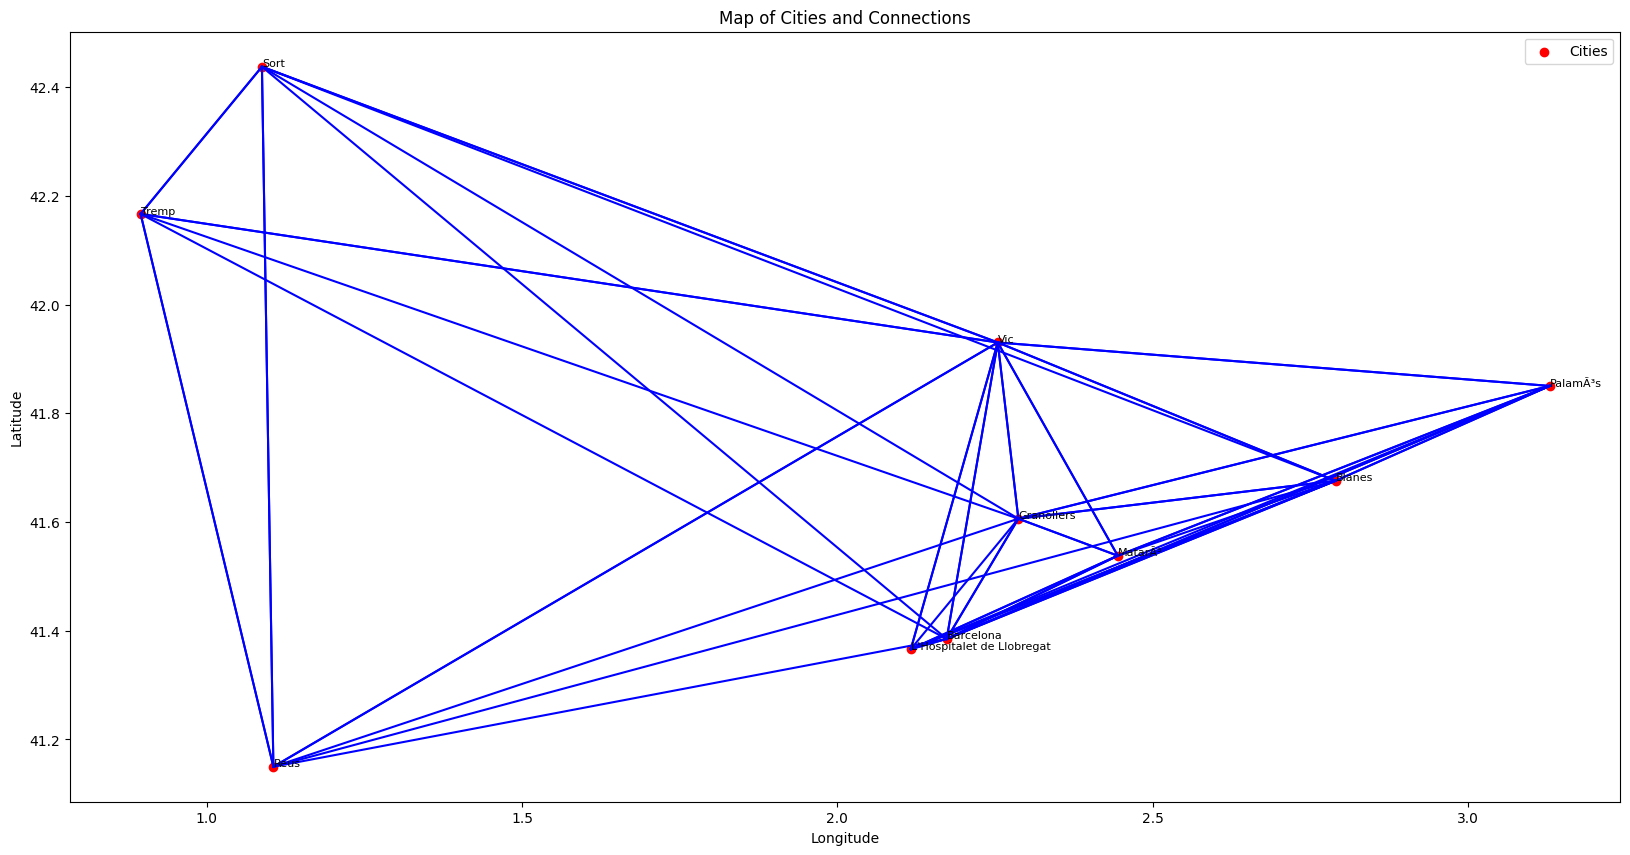

In [14]:
with open('json/2324_GIA04_CA5_Search_data_routes.json') as json_file:
    data = json.load(json_file)

# Convert JSON data to DataFrames for cities and connections
dfcities = pd.DataFrame(data['cities'])
dfconnections = pd.DataFrame(data['connections'])

# Assuming you want to create a map with just cities and connections without using GeoPandas

# Create a larger figure
plt.figure(figsize=(20, 10))

# Plot cities
plt.scatter(dfcities['longitude'], dfcities['latitude'], color='red', label='Cities')

# Plot connections
for i, connection in dfconnections.iterrows():
    from_city = dfcities[dfcities['name'] == connection['from']]
    to_city = dfcities[dfcities['name'] == connection['to']]
    plt.plot([from_city['longitude'], to_city['longitude']], [from_city['latitude'], to_city['latitude']], 'b-')
    
  

# Annotate each city with its name
for idx, row in dfcities.iterrows():
    plt.text(row['longitude'], row['latitude'], row['name'], fontsize=8)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of Cities and Connections')
plt.legend()
plt.show()


### A*

In [15]:
# We are tring to calculate the distance between the diffrent cities
def euclidean_distance(lat1, lon1, lat2, lon2):
    return math.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)

def a_star(start, goal, graph, heuristics):
    L = []
    heapq.heappush(L, (0 + heuristics[start], 0, start, [start]))
    explored = set()

    while L:
        f, g, current_node, path = heapq.heappop(L)
        
        if current_node in explored:
            continue
        
        if current_node == goal:
            return path, g
        
        explored.add(current_node)
        
        for (neighbor, distance) in graph[current_node]:
            if neighbor in explored:
                continue
            
            new_g = g + distance
            new_f = new_g + heuristics[neighbor]
            new_path = path + [neighbor]
            
            heapq.heappush(L, (new_f, new_g, neighbor, new_path))
            
    return None, float('inf')

with open('json/2324_GIA04_CA5_Search_data_routes.json') as json_file:
    data = json.load(json_file)

dfcities = pd.DataFrame(data['cities'])
dfconnections = pd.DataFrame(data['connections'])

listRow = {}
for idx, row in dfcities.iterrows():
    listRow[row['name']] = []

for idx, row in dfconnections.iterrows():
    listRow[row['from']].append((row['to'], row['distance']))

city_coords = {row['name']: (row['latitude'], row['longitude']) for idx, row in dfcities.iterrows()}

def calculate_heuristics(goal, city_coords):
    heuristics = {}
    goal_lat, goal_lon = city_coords[goal]
    for city, (lat, lon) in city_coords.items():
        heuristics[city] = euclidean_distance(lat, lon, goal_lat, goal_lon)
    return heuristics

start = 'Blanes'
goal = 'Barcelona'

heuristics = calculate_heuristics(goal, city_coords)
path, duration = a_star(start, goal, listRow, heuristics)

print(f"Path: {path}")
print(f"Duration: {duration}")


Path: ['Blanes', 'Barcelona']
Duration: 72777


### CSP Constraint Satisfaction Problem

In [16]:
class CSPPathFinder:
    def __init__(self, json_file):
        self.json_file = json_file
        self.graph = None
        self.load_data()

    def load_data(self):
        with open(self.json_file) as file:
            data = json.load(file)
        cities = pd.DataFrame(data['cities'])
        connections = pd.DataFrame(data['connections'])
        
        self.graph = {}
        for idx, row in cities.iterrows():
            self.graph[row['name']] = []

        for idx, row in connections.iterrows():
            self.graph[row['from']].append((row['to'], row['distance'], row['duration']))

    def csp_path_finder(self, start, goal, max_distance, max_duration):
        L = []
        heapq.heappush(L, (0, 0, start, [start]))
        explored = set()

        while L:
            distance, duration, current_node, path = heapq.heappop(L)

            if current_node == goal:
                return path, distance, duration

            if current_node in explored:
                continue

            explored.add(current_node)

            for (neighbor, neighbor_distance, neighbor_duration) in self.graph[current_node]:
                if neighbor in explored:
                    continue
                
                if distance + neighbor_distance <= max_distance and (duration + neighbor_duration/60) <= max_duration:
                    new_distance = distance + neighbor_distance
                    new_duration = duration + neighbor_duration/60  # Convert seconds to minutes
                    new_path = path + [neighbor]
                    heapq.heappush(L, (new_distance, new_duration, neighbor, new_path))

        return None, None, None


csp_path_finder = CSPPathFinder('json/2324_GIA04_CA5_Search_data_routes.json')
start_city = 'Blanes'
goal_city = 'Barcelona'
max_distance = 150000 
max_duration = 90 

path, distance, duration = csp_path_finder.csp_path_finder(start_city, goal_city, max_distance, max_duration)

if path:
    print(f"Valid path found from {start_city} to {goal_city}: {path}")
    print(f"Total distance: {distance} km")
    print(f"Total duration: {duration} minutes")
else:
    print(f"No valid path found from {start_city} to {goal_city} respecting the restrictions.")

start_city = 'Tremp'
max_duration = 90  

path, distance, duration = csp_path_finder.csp_path_finder(start_city, goal_city, max_distance, max_duration)

if path:
    print(f"Valid path found from {start_city} to {goal_city}: {path}")
    print(f"Total distance: {distance} km")
    print(f"Total duration: {duration} minutes")
else:
    print(f"No valid path found from {start_city} to {goal_city} respecting the restrictions.")


Valid path found from Blanes to Barcelona: ['Blanes', 'Barcelona']
Total distance: 72777 km
Total duration: 60.5 minutes
No valid path found from Tremp to Barcelona respecting the restrictions.


##link: https://www.linkedin.com/pulse/heuristics-search-technique-find-shortest-distance-between-pandeya

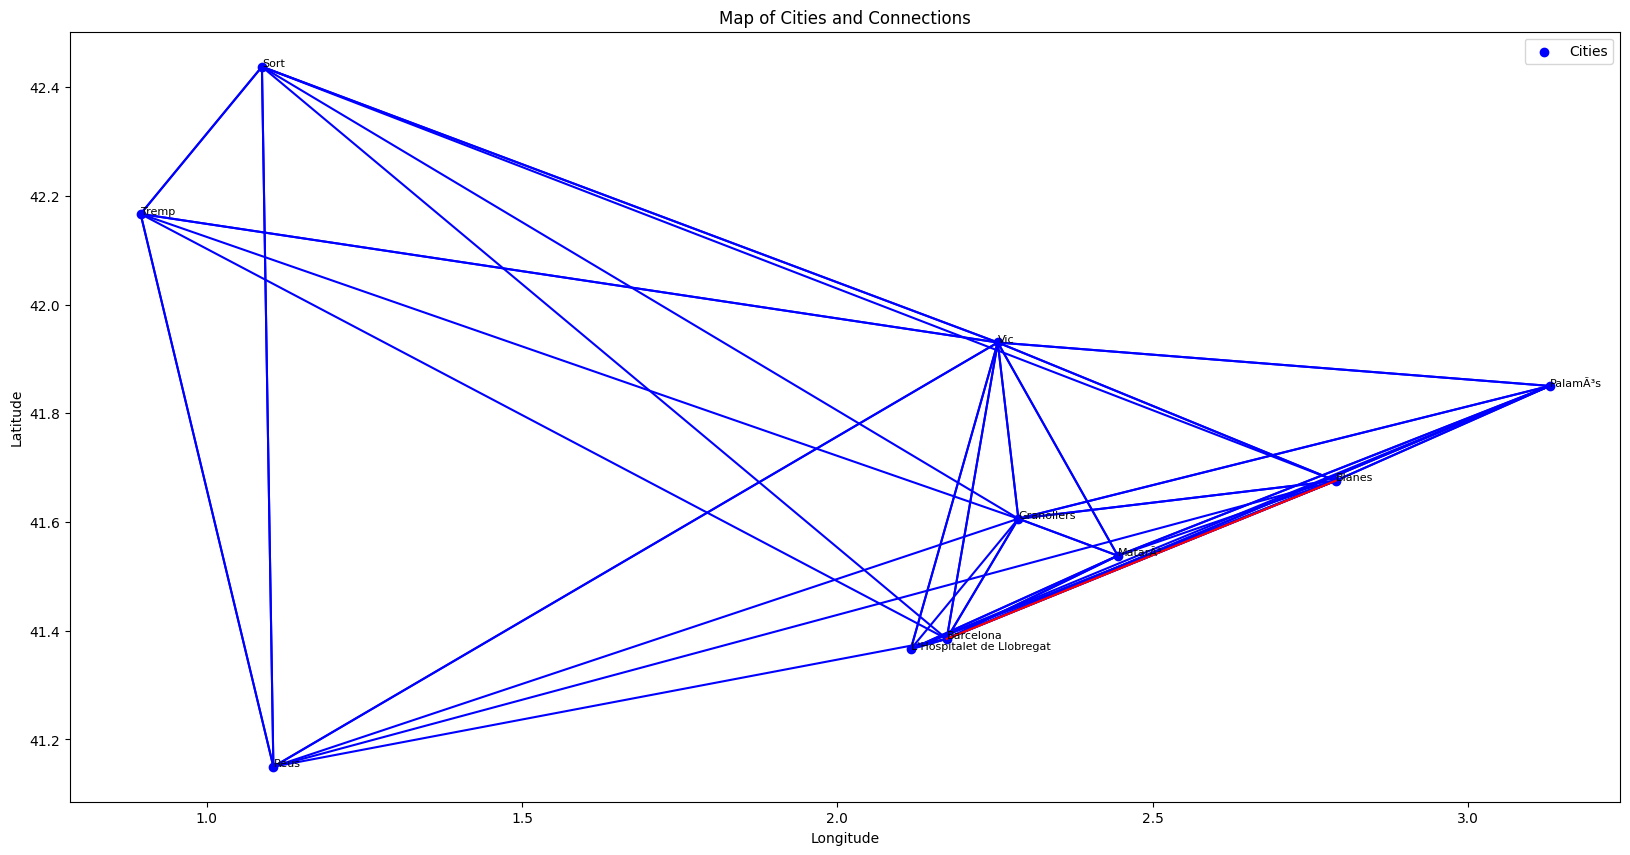

In [17]:
with open('json/2324_GIA04_CA5_Search_data_routes.json') as json_file:
    data = json.load(json_file)

dfcities = pd.DataFrame(data['cities'])
dfconnections = pd.DataFrame(data['connections'])

plt.figure(figsize=(20, 10))

plt.scatter(dfcities['longitude'], dfcities['latitude'], color='blue', label='Cities')

for i, connection in dfconnections.iterrows():
    from_city = dfcities[dfcities['name'] == connection['from']]
    to_city = dfcities[dfcities['name'] == connection['to']]
    plt.plot([from_city['longitude'], to_city['longitude']], [from_city['latitude'], to_city['latitude']], 'b-')

for idx, row in dfcities.iterrows():
    plt.text(row['longitude'], row['latitude'], row['name'], fontsize=8)

# RED LINE from start_city to goal_city
start_city = 'Blanes'
goal_city = 'Barcelona'
path, _, _ = csp_path_finder.csp_path_finder(start_city, goal_city, max_distance, max_duration)
if path:
    for i in range(len(path) - 1):
        from_city = dfcities[dfcities['name'] == path[i]]
        to_city = dfcities[dfcities['name'] == path[i+1]]
        plt.plot([from_city['longitude'], to_city['longitude']], [from_city['latitude'], to_city['latitude']], 'r-')


plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of Cities and Connections')
plt.legend()
plt.show()
